### Imports

In [1152]:
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import os
from numpy.fft import fft2, ifft2
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
from functools import reduce

### Preparing fonts

In [1153]:
def reduce_noise(image, k):
    """ Uses SVD decomposition and low rank approximation to reduce noise in matrix 
    
    :arg
        image: numpy array containg image in grayscale
        k:     number of used signular values in low approximation 
    
    :retuns
        numpy array contating matrix with reduced noise
    """
    u, s, vh = np.linalg.svd(image)

    new_image = np.zeros(image.shape)

    for i in range(k):
        u_i = u[:, i].reshape(-1, 1)
        vh_i = vh[i].reshape(1, -1)

        new_image += s[i] * (u_i @ vh_i)

    new_image = new_image.astype(dtype=np.uint8)
    
    return new_image


def get_image(file_path, original=False, to_grayscale=False, do_reduce_noise=False, k=1):
    """ Gets image from file and optionally making several operations on it
    
    :arg
        file_path:       path of the image
        original:        whether the image will have inverted colors or not
        to_grayscale:    whether the image will be converted to grayscale or not 
                         in case "original" = True
        do_reduce_noise: whether reduce noise by SVD decomposition and low rank approximation or not
        k:               number of iterations in low rank approximation
        
    :returns
        numpy array with the image after operations made on it 
    """
    image = Image.open(file_path)
    
    if not original:
        image = image.convert("L")
        image = PIL.ImageOps.invert(image)
    elif to_grayscale:
        image = image.convert("L")
    
    image_array = np.array(image)
    
    if do_reduce_noise:
        image_array = reduce_noise(image_array, k)
        
    return image_array
        
        
def get_lines(image_array, threshold, make_equal_length=True):
    """ Gets x coordinates of lines in the text
    
    :arg
        image_array:       numpy array containing image
        threshold:         sum of pixel values in row which is minimal to classify row
                           as part of a line
        make_equal_length: if length of lines shoulf be equal or not
        
    :returns:
        list of tuples - x coordinates of start and end of every line
    """
    curr_line = 0
    
    lines = []
    line_lengths = []
    
    in_line = False
    line_start = 0
    line_end = 0
    
    for i in range(image_array.shape[0]):
        line_sum = image_array[i].sum()

        if not in_line and line_sum > threshold:
            if len(lines) > 0 and i - lines[len(lines) - 1][1] < 5:
                lines.pop()
                line_lengths.pop()
            else:
                line_start = i
                
            in_line = True
            
        elif in_line and line_sum < threshold and i - line_start > 5:
            lines.append((line_start, i))
            line_lengths.append(i - line_start)
            
            line_end = i
            in_line = False
            
    # deleting too short lines which were added by mistake
    too_short = []

    for i in range(len(lines)):
        if lines[i][1] - lines[i][0] < 10:
            too_short.append(i)

    for index in reversed(too_short):
        lines.pop(index)
        line_lengths.pop(index)
            
    # (optionally) making all lines have equal length
    if make_equal_length:
        best_length = sum(line_lengths) // len(line_lengths)
        for i in range(len(lines)):
            if line_lengths[i] != best_length:
                lines[i] = (lines[i][0], lines[i][0] + best_length)
            
    return lines


def get_columns(image_array, threshold):
    """ Gets y coordinates of all positions of characters
    
    :arg
        image_array: array containg image with text
        threshold:   sum of pixel values in column which is minimal to classify it
                     as part of character positions
    
    :return
        list of tuples - y coordinates of start and end of character positions
    """
    curr_col = 0
    
    columns = []
    
    in_column = False
    column_start = 0
    column_end = 0
    
    for i in range(image_array.shape[1]):
        column_sum = image_array[:, i].sum()
        
        if not in_column and column_sum > threshold:
            column_start = i
            in_column = True
            
        elif in_column and column_sum < threshold:
            if i - column_start > 5:
                columns.append((column_start, i))
                
            column_end = i
            in_column = False
    
    return columns
    
        
def crop_letters(image_array, threshold, save=False):
    """ Divides image with text into letters to use them in the future
    
    :arg
        image_array: numpy array contatining image
        threshold:   minimal sum of row and column to classify them as part of text
        save:        whether to save the letters to "ocr/letters" directory
    
    :return
        list of numpy arrays contatining letters
    """
    lines = get_lines(image_array, threshold)
    columns = get_columns(image_array, threshold)
    
    image = Image.fromarray(image_array)
    letters = []
    
    for i in range(len(lines)):
        for j in range(len(columns)):
            letter = image.crop((columns[j][0], lines[i][0], columns[j][1], lines[i][1]))
            letters.append(np.array(letter))
            
            if save:
                with open(f"ocr/letters/{i*len(columns) + j}.jpg", "w+"):
                    pass

                letter.save(f"ocr/letters/{i*len(columns) + j}.jpg")

    return letters


def separate_coordinates(points):
    """ Separates points' coordinates for drawing them on the plot 
    
    :arg
        points: list of objects of class Point
    
    :returns
        two list of coordinates: x, y
    """
    points_x = list(map(lambda point: point.coords[0], points))
    points_y = list(map(lambda point: point.coords[1], points))

    return points_x, points_y


def show_image(image, points=[]):
    """ Shows text image and scatters points 
    
    :arg
        image:  numpy array containing image
        points: points which will be drawn at the plot to show where characters were found
    """
    fig, ax = plt.subplots(1, 1, figsize=(15,10))

    ax.imshow(image, cmap='gray')
    
    points_x, points_y = separate_coordinates(points)
    ax.scatter(points_x, points_y, c="#FF0000", s=5)
    
    plt.show()

#### Courier New

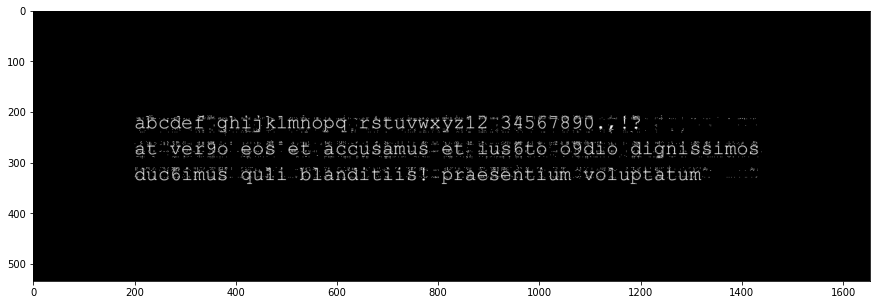

In [1155]:
image = get_image("ocr/courier_new_test.jpg", do_reduce_noise=True, k=80)

letters = crop_letters(image, 400, False)

show_image(image)

#### Cutive Mono

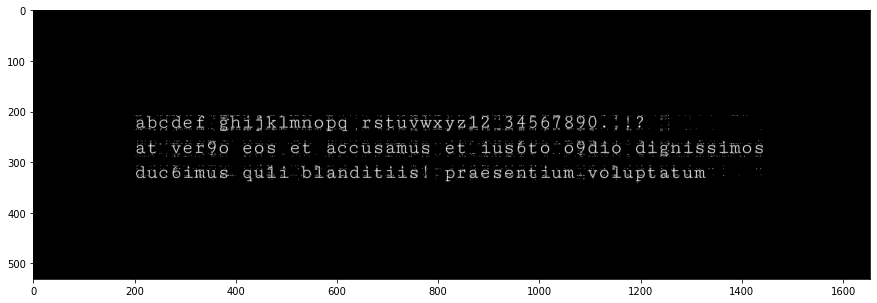

In [1156]:
image = get_image("ocr/cutive_mono_test.jpg", do_reduce_noise=True, k=80)

letters = crop_letters(image, 400, False)

show_image(image)

#### Roboto Mono

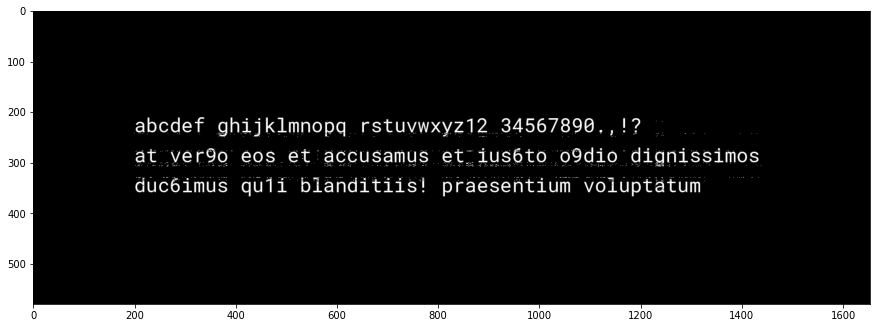

In [1157]:
image = get_image("ocr/roboto_mono_test.jpg", do_reduce_noise=True, k=100)

letters = crop_letters(image, 600, False)

show_image(image)

### Reading from images

In [1158]:
# some global final variables for rotation
rotation_thresholds = dict()
rotation_thresholds["courier_new"] = [("a.jpg", 3*10**6), ("e.jpg", 3*10**6), ("i.jpg", 3*10**6)]
rotation_thresholds["roboto_mono"] = [("a.jpg", 8.5*10**6), ("e.jpg", 8.5*10**6), ("i.jpg", 8.5*10**6)]
rotation_thresholds["cutive_mono"] = [("a.jpg", 3*10**6), ("e.jpg", 3*10**6), ("i.jpg", 3*10**6)]

In [1168]:
rows_threshold = 800
columns_threshold = 500
margin = 4

class Point:
    """ Class represents point on which character was found """
    def __init__(self, coords, character, correlation):
        self._coords = coords
        self._character = character
        self._correlation = correlation
        
    def __lt__(self, other):
        """ Useful when sorting points. Points are divided into lines and y coordinate
            is not important when points are in the same line.
        """
        if abs(self.coords[1] - other.coords[1]) > 2 * margin:
            return True if self.coords[1] < other.coords[1] else False
        else:
            return True if self.coords[0] < other.coords[0] else False
        
    def __eq__(self, other):
        """ Useful when extracting characters because many points can have high correlation
            in specific area but just one point should be chosen to tell what character was
            found there.
        """
        if type(self) == type(other) and \
        abs(self.coords[0] - other.coords[0]) <= 2 * margin and \
        abs(self.coords[1] - other.coords[1]) <= 2 * margin:
            return True
        
        return False
        
    
    def __hash__(self):
        return hash(self._coords)
    
    @property
    def coords(self):
        return self._coords
    
    @property
    def character(self):
        return self._character
    
    @property
    def correlation(self):
        return self._correlation
    
    
def rotate(image, angle, default_color=255):
    """ Rotating image by 90, 180 or 270 degrees
    
    :arg
        image:         numpy array containing image to rotate
        angle:         angle of which the image should be rotated
        default_color: in case of angle == 90 or angle == 270 it is needed 
                       to reshape array so this color will be in the new cells
                       
    :returns
        rotated image sa numpy array
    """
    n, m = image.shape
    
    # making square array to rotate it and not lose any pixel
    # when angle = 90 or angle = 270
    square_image = image
    if angle == 90 or angle == 270:
        if n > m:
            square_image = np.empty((n, n))
            square_image[:, :m] = image
            square_image[:, m:] = default_color
        elif m > n:
            square_image = np.empty((m, m))
            square_image[:n, :] = image
            square_image[n:, :] = default_color
    
    square_image = inter.rotate(square_image, angle, reshape=False, order=0)
    
    # making correct size of the image
    image = square_image
    if angle == 90:
        if n > m:
            image = np.empty((m, n))
            image = square_image[(n-m):, :]
        elif m > n:
            image = np.empty((m, n))
            image = square_image[:, :n]
            
            
    elif angle == 270:
        if n > m:
            image = np.empty((m, n))
            image = square_image[:m, :]
        elif m > n:
            image = np.empty((m, n))
            image = square_image[:, (m-n):]    
            
    return image
    

def get_possible_rows(image):
    """ Gets all possible rows in which character can be found 
    
    :arg
        image: numpy array contating image
        
    :returns
        set of integers: possible rows
    """
    possible_rows = set()
    
    lines = get_lines(image, rows_threshold)
    
    for line in lines:
        possible_rows |= set([x for x in range(line[1] - margin, line[1] + margin + 1)])
        
    return possible_rows
    
    
def get_possible_columns(image):
    """ Gets all possible columns in which character can be found 
    
    :arg
        image: numpy array contating image
        
    :returns
        set of integers: possible columns
    """
    possible_columns = set()
    
    columns = get_columns(image, columns_threshold)
    
    for column in columns:
        possible_columns |= set([y for y in range(column[1] - margin, column[1] + margin + 1)])
        
    mean_width = reduce(lambda a, b: a + b, map(lambda a: a[1] - a[0], columns)) / len(columns)
    
    return possible_columns, mean_width


def get_patterns(path):
    """ Gets list of paths to all character patterns 
    
    :arg
        path: path of the directory
        
    :return
        list of strings containing names of the files with character patterns
    """
    return os.listdir(path)


def get_occurrence(image, pattern, possible_rows, possible_columns, pattern_name, threshold):
    """ Gets all possible occurences of character using discrete Fourier transform
    
    :arg
        image:            image as numpy array
        pattern:          pattern as numpy array
        possible_rows:    possible rows in which patterns can be found
        possible_columns: possible columns in which patterns can be found
        pattern_name:     character which funtion is looking for
        threshold:        minimal correlation to classify position as contating pattern
        
    :return
        list of objects of class Point: found occurences of pattern
    """
    occurrence = np.real(ifft2(fft2(image) * fft2(np.rot90(pattern, 2), image.shape)))
    
    highlighted_points = []
    
    for i in range(occurrence.shape[0]):
        for j in range(occurrence.shape[1]):
            if occurrence[i, j] > threshold and i in possible_rows and j in possible_columns:
                highlighted_points.append(Point((j, i), pattern_name[0], occurrence[i, j]))

    return highlighted_points


def check_rotation(image, patterns_path):
    """ Checks if the image should be rotated by 90, 180 or 270 degrees
    
    :arg
        image:         numpy array containing image
        patterns_path: path of the directory with patterns
        
    :returns
        - numpy array containing rotated image
        - angle of which the image was rotated
        
    Note:
        function is checking if there is enough good correlations for letters:
        a, e and i in first two lines of the rotated image. It is highly probable that
        there will be at least one of these letters in first two lines.
    """
    rotation_score = dict()
    
    for angle in [0, 90, 180, 270]:
        # rotating image
        curr_image = rotate(image, angle, default_color=0)
        
        # getting first 2 rows of the rotated image (or less if there is less than 2 lines)
        possible_rows = set()

        lines = get_lines(curr_image, rows_threshold, make_equal_length=False)

        for i in range(min(len(lines), 2)):
            possible_rows |= set([x for x in range(lines[i][1] - margin, lines[i][1] + margin + 1)])

        smaller_image = np.empty((lines[min(len(lines)-1, 1)][1] + 20, curr_image.shape[1]))
        smaller_image = curr_image[:smaller_image.shape[0], :]
        
        
        # getting all possible columns of the rotated image
        possible_columns, _ = get_possible_columns(image)

        # getting all occurrences of these three vowels
        for i in range(len(patterns_path)):
            if patterns_path[4:i] in rotation_thresholds:
                pattern_threshold = rotation_thresholds[patterns_path[4:i]]
                break
        
        best_points = []
        
        for pattern, threshold in pattern_threshold:
            pattern_array = get_image(f"{patterns_path}/{pattern}", original=True)

            best_points += get_occurrence(smaller_image, pattern_array, 
                                                 possible_rows, possible_columns,
                                                 pattern, threshold)

        # getting sum of correlation from all found points
        rotation_score[angle] = 0
        for point in best_points:
            rotation_score[angle] = max(point.correlation, rotation_score[angle])            
    
    # getting best angle
    best_angle = 0
    for angle, score in rotation_score.items():
        if score > rotation_score[best_angle]:
            best_angle = angle
    
    image = rotate(image, best_angle, default_color=0)
    
    return image, best_angle
            

def extract_characters(points, character_width):
    """ Gets characters from points with high correlation value 
    
    :arg
        points:          list of objects of class Point - points where there is high 
                         correlation value
        character_width: integer needed to check whether was space or not
        
    :returns
        string representing read text
    """
    text = ""
    
    curr_best = points[0]
    
    for i in range(1, len(points)):
        if points[i-1] == points[i] and points[i].correlation > curr_best.correlation:
            curr_best = points[i]
        elif points[i-1] != points[i]:
            text += curr_best.character
            curr_best = points[i]
            
            if points[i].coords[1] - points[i-1].coords[1] > 2 * margin:
                text += "\n"
            elif points[i].coords[0] - points[i-1].coords[0] > 1.5 * character_width:
                text += " "
    
    text += curr_best.character
    
    return text

    
def read_text(image_path, patterns_path, threshold, k):
    """ Reading text from image using discrete Fourier transform
    
    :arg
        image_path:    string contating path to the image with text
        patterns_path: path to the directory with patterns of characters
        threshold:     minimal number to classify whether is good correlation
                       at given point or not
        k:             number of iteration in low rank approximation of image
    
    :return
        - text read from file (string)
        - points with best correlation (list of Points)
    """
    
    # operations on image
    image_array = get_image(image_path)
    image_array, angle = check_rotation(image_array, patterns_path)
    image_array = reduce_noise(image_array, k)
    
    # possible places where characters will be read
    possible_rows = get_possible_rows(image_array)
    possible_columns, column_width = get_possible_columns(image_array)
    
    # getting best correlation points
    best_points = []
    
    for pattern in get_patterns(patterns_path):
        pattern_array = get_image(f"{patterns_path}/{pattern}", original=True)
        
        best_points += get_occurrence(image_array, pattern_array, 
                                             possible_rows, possible_columns,
                                             pattern, threshold)

    # getting text
    best_points.sort()
    text = extract_characters(best_points, column_width)

    # printing result and showing image with text and best points
    print(f"\n{text}")

    original_image = get_image(image_path, original=True, to_grayscale=True)
    original_image = rotate(original_image, angle)

    show_image(original_image, best_points)
    
    return text, best_points



def edit_distance(x, y):
    """ Calculates edit distance

    :arg
        x, y:         texts between which edit distance is calculated

    :returns
        edit distance as integer
    """

    def delta(a, b):
        """ Function calculating distance between two letters

        :arg
            a,b: letters which there will be calculated edit distance

        :returns
            if the arguments are the same: 0; otherwise 1
        """

        if a == b:
            return 0
        else:
            return 1
    
    # initializing table by filling first row and column
    edit_table = np.empty((len(x) + 1, len(y) + 1))
    for i in range(len(x) + 1):
        edit_table[i, 0] = i
    for j in range(len(y) + 1):
        edit_table[0, j] = j

    # filling all the 2d array
    for i in range(1, len(x) + 1):
        for j in range(1, len(y) + 1):
            # getting minimal edit distance to get to this position in array and position itself
            minimum, position = min((edit_table[i-1, j] + 1, (i-1, j)),
                                    (edit_table[i, j-1] + 1, (i, j-1)),
                                    (edit_table[i-1, j-1] + delta(x[i-1], y[j-1]), (i-1, j-1)))
            edit_table[i, j] = minimum

    return edit_table[len(x), len(y)]


def count_letters(text):
    """ Counts letters and show their occurrences in read text
    
    :arg
        text: read text with letters to count
    """
    letter_counts = dict()
    
    letters = list(map(chr, range(ord('a'), ord('z')+1)))
    
    for character in text:
        if character in letters:
            if character in letter_counts:
                letter_counts[character] += 1
            else:
                letter_counts[character] = 1
                
    letter_counts = list(letter_counts.items())
    letter_counts.sort()
    
    for letter, occurrences in letter_counts:
        print(f"{letter}: {occurrences}", end="   ")    
    
    

def check_correctness(text):
    """ Prints some information about correctness of the read text
    
    :arg
        text: text read from image
    """
    with open("ocr/text.txt", "r") as file:
        correct_text = file.read()[:-1]
        
        correct_characters = 0
        for i in range(min(len(text), len(correct_text))):
            if text[i] == correct_text[i]:
                correct_characters += 1
                
        edit_dist = edit_distance(text, correct_text)
                
        print(f"Edit distance: {int(edit_dist)}")
        print(f"Number of characters: {len(text)}")
        print(f"Correctness: {(100 * correct_characters / len(text)):.1f}%")
        count_letters(text)

In [1081]:
# rotating
image = Image.open("ocr/cutive_mono2.jpg")
# image = image.rotate(270)
image = image.convert("L")    
image = np.array(image)
image = rotate(image, 270, default_color=255)
# show_image(image)
image = Image.fromarray(image)
with open("ocr/cutive_mono_270.jpg", "w+"):
    pass
image = image.convert("RGB")    
image.save("ocr/cutive_mono_270.jpg")

#### Courier New

In [1202]:
# for this font it is better if margin = 3
margin = 3


molestias excepturi sint occaecati. cupiditate non
at vero, eos et 1475234 accusamus et iustoy odio?
dignissimos ducimus qui blanditiis! 968140. voluptati


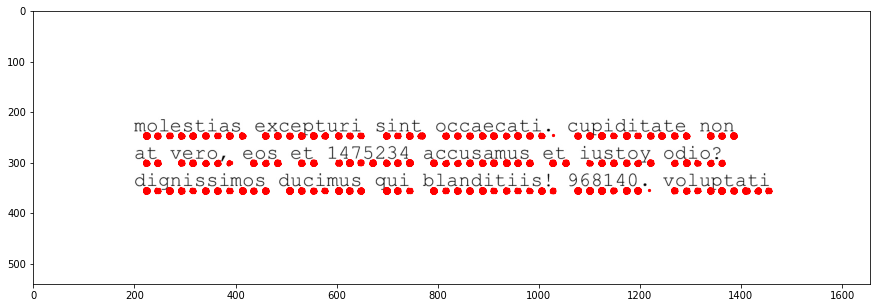

Edit distance: 0
Number of characters: 154
Correctness: 100.0%
a: 9   b: 1   c: 8   d: 5   e: 9   g: 1   i: 17   l: 3   m: 4   n: 5   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   v: 2   x: 1   y: 1   

In [1203]:
# example of situation with 100% correctness but all variables are perfectly set to achieve it
columns_threshold = 350
text, points = read_text("ocr/courier_new.jpg", "ocr/courier_new_2", 1.35 * 10 ** 6, k=90)

check_correctness(text)


molestias excepturi sint occaecati. cupiditate non
at vero, eos et 1475234 accusamus et iustoy odio?
dignissimos ducimus qui blanditiis! 968140. voluptatm


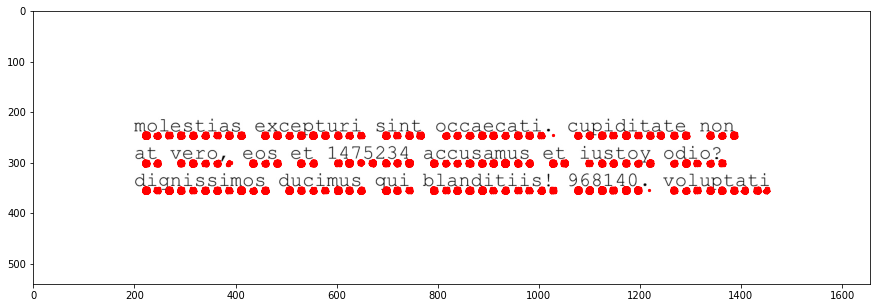

Edit distance: 1
Number of characters: 154
Correctness: 99.4%
a: 9   b: 1   c: 8   d: 5   e: 9   g: 1   i: 16   l: 3   m: 5   n: 5   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   v: 2   x: 1   y: 1   

In [1170]:
# no rotation
columns_threshold = 500
text, points = read_text("ocr/courier_new.jpg", "ocr/courier_new_2", 1.35 * 10 ** 6, k=90)

check_correctness(text)


molestias excepturi sint occaecati. cupiditate non
at vero, eos et 1475234 accusamus et iustoy odio?
dignissimos ducimus qui blanditiis! 968140. voluptatd


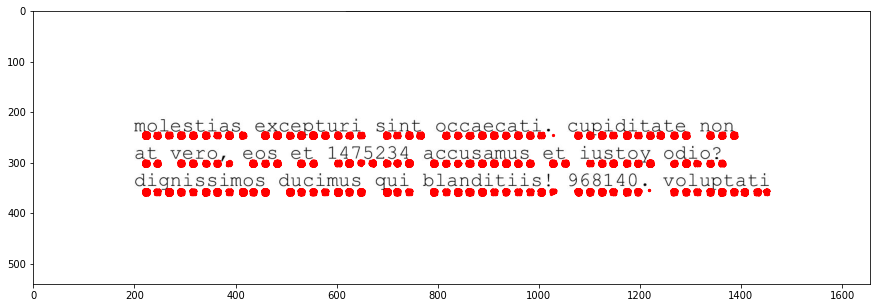

Edit distance: 1
Number of characters: 154
Correctness: 99.4%
a: 9   b: 1   c: 8   d: 6   e: 9   g: 1   i: 16   l: 3   m: 4   n: 5   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   v: 2   x: 1   y: 1   

In [1171]:
# 90 degrees rotation
text, points = read_text("ocr/courier_new_90.jpg", "ocr/courier_new_2", 1.35 * 10 ** 6, k=90)

check_correctness(text)


molestias excepturi sint occaecati, cupiditate non
at vero, eos et 1475234 accusamus et iustoy odio?
dignissimos ducimus qui blanditiis! 968140. voluptatm


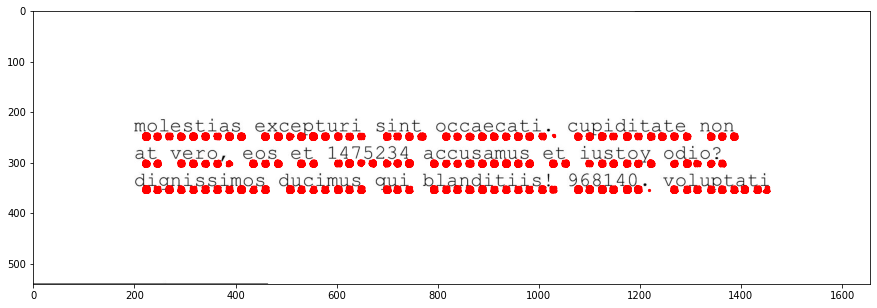

Edit distance: 2
Number of characters: 154
Correctness: 98.7%
a: 9   b: 1   c: 8   d: 5   e: 9   g: 1   i: 16   l: 3   m: 5   n: 5   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   v: 2   x: 1   y: 1   

In [1174]:
# 180 degrees rotation
text, points = read_text("ocr/courier_new_180.jpg", "ocr/courier_new_2", 1.35 * 10 ** 6, k=90)

check_correctness(text)


molestias excepturi sint occaecati, cupiditate non
at vero, eos et 1475234 accusamus et iustoy odio?
dignissimos ducimus qui blanditiis! 968140. voluptati


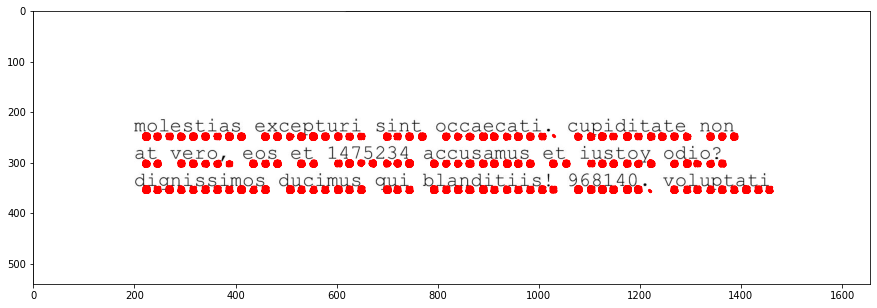

Edit distance: 1
Number of characters: 154
Correctness: 99.4%
a: 9   b: 1   c: 8   d: 5   e: 9   g: 1   i: 17   l: 3   m: 4   n: 5   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   v: 2   x: 1   y: 1   

In [1173]:
# 180 degrees rotation
text, points = read_text("ocr/courier_new_270.jpg", "ocr/courier_new_2", 1.35 * 10 ** 6, k=90)

check_correctness(text)

#### Cutive Mono

In [1135]:
# for this font it is better if margin = 4
margin = 4


molestias exoepturi sint oooaeoati. oupiditate non
at yero, eos et 1475234 aoousamus et iustoy odio?
dignissimos duoimus qui blanditiis1 968140. yoluptati


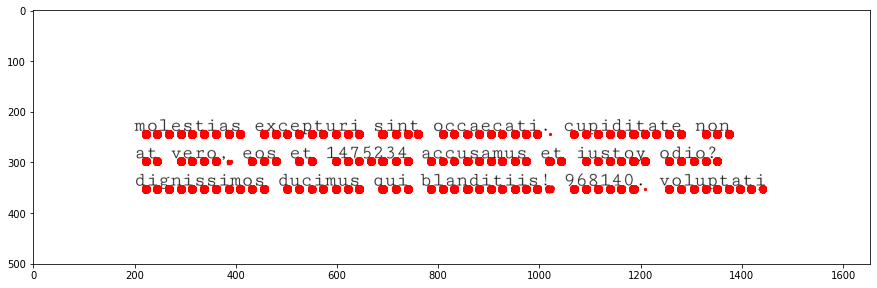

Edit distance: 11
Number of characters: 154
Correctness: 92.9%
a: 9   b: 1   d: 5   e: 9   g: 1   i: 17   l: 3   m: 4   n: 5   o: 18   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   x: 1   y: 3   

In [1175]:
# no rotation, many iterations of low rank approximation for both image and patterns
text, points = read_text("ocr/cutive_mono.jpg", "ocr/cutive_mono_1", 0.7 * 10 ** 6, k=120)

check_correctness(text)


mo1estias exoepturi sint oooaecati. cupiditate non
at yerop eos et 1475234 acousamus et iustoy odio?
dignissimos duoimus qui blanditiis1 968140. yoluptati


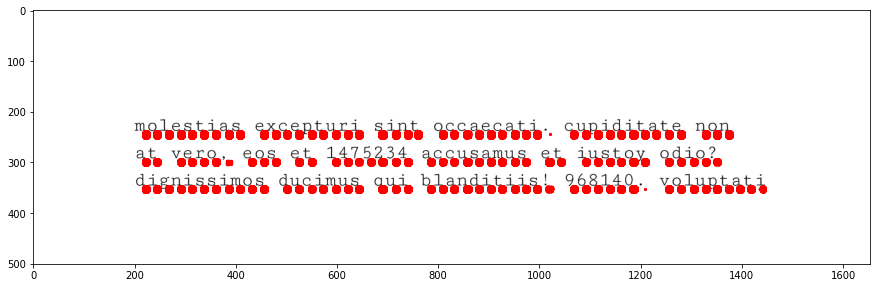

Edit distance: 10
Number of characters: 154
Correctness: 93.5%
a: 9   b: 1   c: 3   d: 5   e: 9   g: 1   i: 17   l: 2   m: 4   n: 5   o: 15   p: 4   q: 1   r: 2   s: 12   t: 13   u: 9   x: 1   y: 3   

In [1177]:
# no rotation, fewer iterations of low rank approximation for both image and patterns
# (makes better result)
text, points = read_text("ocr/cutive_mono.jpg", "ocr/cutive_mono_2", 0.75 * 10 ** 6, k=85)

check_correctness(text)


mo1estias excepturi sint oooaecatiw cupiditatefnon
at verop eos et 1475234 aocusamus et iustoy odio?
dignissimos dudimus qui blanditiis1 968140. yoluptati


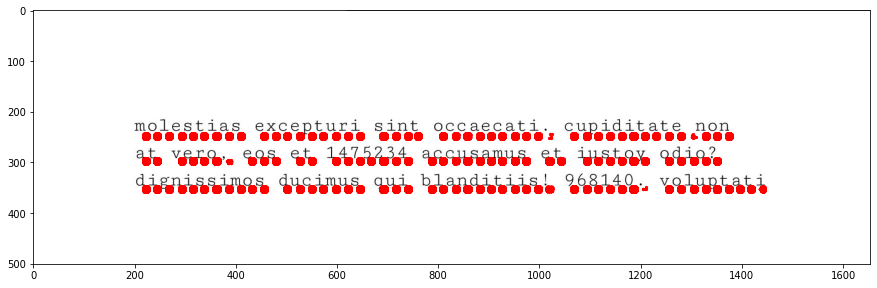

Edit distance: 10
Number of characters: 154
Correctness: 93.5%
a: 9   b: 1   c: 4   d: 6   e: 9   f: 1   g: 1   i: 17   l: 2   m: 4   n: 5   o: 13   p: 4   q: 1   r: 2   s: 12   t: 13   u: 9   v: 1   w: 1   x: 1   y: 2   

In [1178]:
# 90 degrees rotation
text, points = read_text("ocr/cutive_mono_90.jpg", "ocr/cutive_mono_2", 0.75 * 10 ** 6, k=85)

check_correctness(text)


mo1estias exoepturi sint ocdaedatix oupiditategnon
at veroh eos et 1475234 aocusamus et iustoy odio?
dignissimos dudimus qui blahditiis1 968140n voluptati


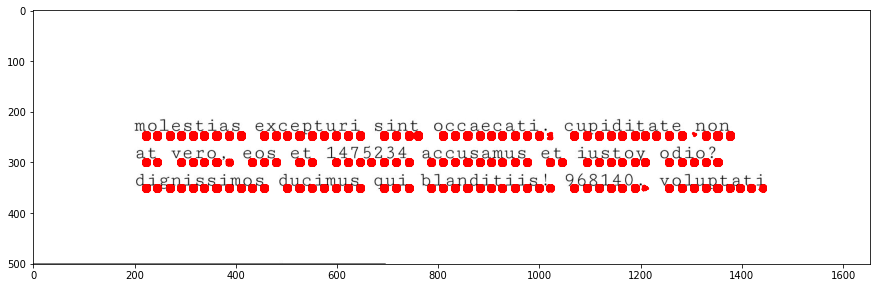

Edit distance: 13
Number of characters: 154
Correctness: 91.6%
a: 9   b: 1   c: 2   d: 8   e: 9   g: 2   h: 2   i: 17   l: 2   m: 4   n: 5   o: 13   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   v: 2   x: 2   y: 1   

In [1179]:
# 180 degrees rotation
text, points = read_text("ocr/cutive_mono_180.jpg", "ocr/cutive_mono_2", 0.75 * 10 ** 6, k=85)

check_correctness(text)


mo1estias exoepturi sint occaedatil cupiditate non
at verog eos et 1475234 aooueamus et iustoyoodio?
dignissimos ducimue qui blanditiis1 968140. yoluptati


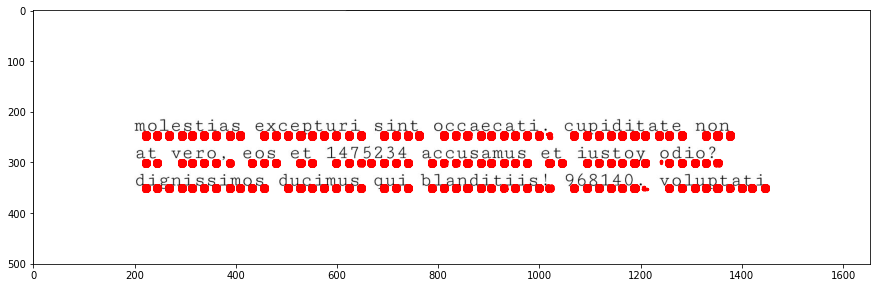

Edit distance: 12
Number of characters: 154
Correctness: 92.2%
a: 9   b: 1   c: 4   d: 6   e: 11   g: 2   i: 17   l: 3   m: 4   n: 5   o: 14   p: 3   q: 1   r: 2   s: 10   t: 13   u: 9   v: 1   x: 1   y: 2   

In [1181]:
# 270 degrees rotation
text, points = read_text("ocr/cutive_mono_270.jpg", "ocr/cutive_mono_2", 0.75 * 10 ** 6, k=85)

check_correctness(text)

#### Roboto Mono

In [1182]:
# it is better for this font if margin = 4
margin = 4


molestias exgepturi siht oggaegati4 gupiditate hoh
at yeroy eos et 1475234 aggusamus et iustoy odio?
dighissimos dugimus qui blahditiis! 968140y yoluptati


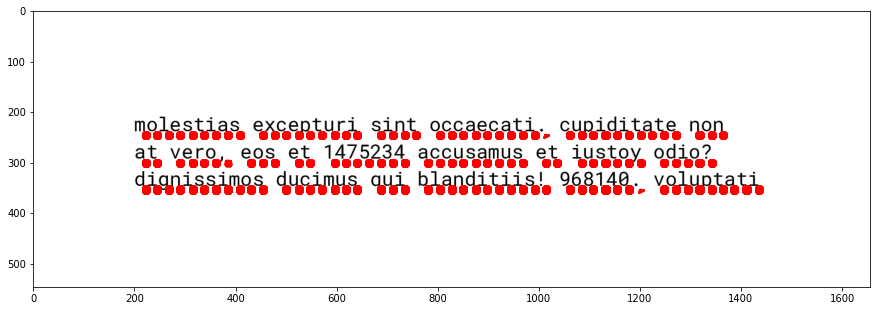

Edit distance: 18
Number of characters: 154
Correctness: 88.3%
a: 9   b: 1   d: 5   e: 9   g: 9   h: 5   i: 17   l: 3   m: 4   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   x: 1   y: 5   

In [1201]:
# no rotation
text, points = read_text("ocr/roboto_mono.jpg", "ocr/roboto_mono_1", 1.35 * 10 ** 6, k=130)

check_correctness(text)


molestias exgepturi siht oggaegati4 gupiditate hoh
at yerol eos et 1475234 aggusamus et iustoy odio?
dighissimos dugimus qui blahditiis! 968140y yoluptati


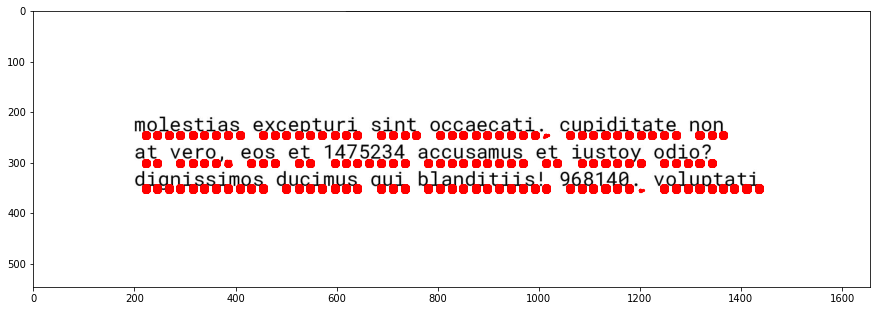

Edit distance: 18
Number of characters: 154
Correctness: 88.3%
a: 9   b: 1   d: 5   e: 9   g: 9   h: 5   i: 17   l: 4   m: 4   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   x: 1   y: 4   

In [1191]:
# 90 degrees rotation
text, points = read_text("ocr/roboto_mono_90.jpg", "ocr/roboto_mono_1", 1.35 * 10 ** 6, k=130)

check_correctness(text)


molestias exgepturi siht oggaegatiy gupiditate hoh
at yerol eos et 1475234 aggusamus et iustoy odio?
dighissimos dudimus qui blahditiis! 968140y yoluptati


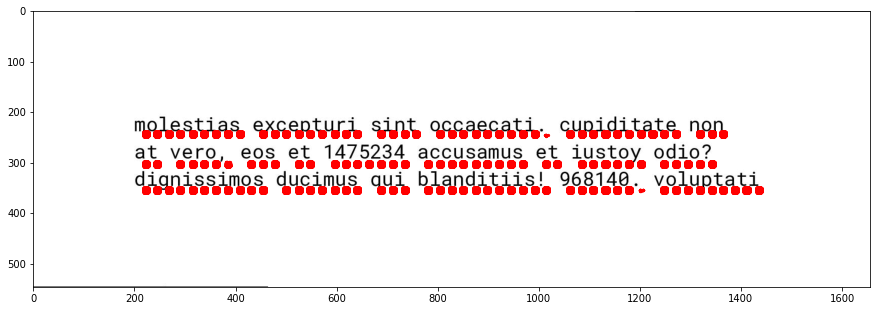

Edit distance: 18
Number of characters: 154
Correctness: 88.3%
a: 9   b: 1   d: 6   e: 9   g: 8   h: 5   i: 17   l: 4   m: 4   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   x: 1   y: 5   

In [1192]:
# 180 degrees rotation
text, points = read_text("ocr/roboto_mono_180.jpg", "ocr/roboto_mono_1", 1.35 * 10 ** 6, k=130)

check_correctness(text)


molestias exgepturi siht odgaegati4 gupiditate hoh
at yerol eos et 1475234 agdusamus et iustoy odio?
dighissimos dudimus qui blahditiis! 968140y yoluptati


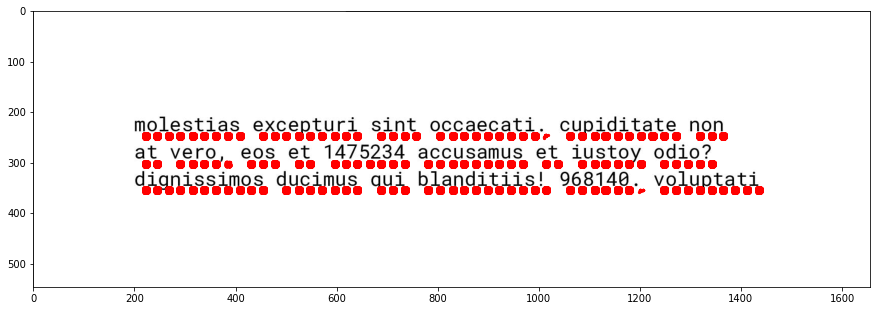

Edit distance: 18
Number of characters: 154
Correctness: 88.3%
a: 9   b: 1   d: 8   e: 9   g: 6   h: 5   i: 17   l: 4   m: 4   o: 10   p: 3   q: 1   r: 2   s: 12   t: 13   u: 9   x: 1   y: 4   

In [1200]:
# 270 degrees rotation
text, points = read_text("ocr/roboto_mono_270.jpg", "ocr/roboto_mono_1", 1.35 * 10 ** 6, k=130)

check_correctness(text)